In [3]:
library(tidyverse)
library(repr)
library(tidymodels)
library(lubridate)
library(dplyr) 
library(themis)
library(RColorBrewer)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# Group Project Report

## Overview
The dataset includes two files:
- **players.csv**: Contains information about each unique player.
- **sessions.csv**: Contains details of individual play sessions for each player.

## Project Question
The question we want to answer is: *"How do experience level, age, and start time influence player behavior, particularly in terms of peak simultaneous activity and total session time played?"*

### Response and Explanatory Variables
- **Response Variable**: `number_of_simultaneous_players` (The number of players connected during specific time windows)
- **Explanatory Variables**: `start_time` (Start time of sessions), `end_time` (End time of sessions), `played_hours` (Total hours played by players)

### Explanation
Analyzing the session data, including `start_time`, `end_time`, and `played_hours`, will help identify patterns in player activity. This insight will allow us to forecast peak times and predict high-demand windows effectively. Understanding these patterns supports better resource management, ensuring the server can accommodate all parallel users efficiently.

## Variable Summary for `players_data`
| Variable Name       | Data Type    | Description                                    | Issues/Notes                          |
|---------------------|--------------|------------------------------------------------|---------------------------------------|
| `experience`        | Character    | Player's level of experience (e.g., Pro, Veteran, Amateur) | None                                 |
| `subscribe`         | Logical      | Indicates whether the player is subscribed (TRUE/FALSE) | None                                 |
| `hashedEmail`       | Character    | Hashed version of the player's email for identification | Used as an identifier, not human-readable |
| `played_hours`      | Numeric      | Total number of hours the player has played   | Check for outliers in high values    |
| `name`              | Character    | Player's first name                            | Potential data privacy concern       |
| `gender`            | Character    | Gender of the player (e.g., Male, Female)      | Ensure consistent formatting         |
| `age`               | Numeric      | Age of the player                              | Check for outliers (e.g., age = 99)  |
| `individualId`      | Logical      | Individual ID (all NA values)                  | All values are missing (NA)          |
| `organizationName`  | Logical      | Name of the player's organization (all NA values) | All values are missing (NA)          |

## Variable Summary for `sessions_data`
| Variable Name         | Data Type    | Description                                    | Issues/Notes                          |
|-----------------------|--------------|------------------------------------------------|---------------------------------------|
| `hashedEmail`         | Character    | Hashed version of the player's email for identification | Used as an identifier to link with `players_data` |
| `start_time`          | Character    | Start time of the play session (format: "DD/MM/YYYY HH:MM") | Needs conversion to datetime format |
| `end_time`            | Character    | End time of the play session (format: "DD/MM/YYYY HH:MM") | Needs conversion to datetime format |
| `original_start_time` | Numeric      | Original start time in a numeric format (timestamp) | Ensure consistency with `start_time` |
| `original_end_time`   | Numeric      | Original end time in a numeric format (timestamp) | Ensure consistency with `end_time`; 2 missing values |

## How Was the Data Collected?
The data was collected from a MineCraft server set up by a research group at UBC, which records player activity and session details as players interact with the game. This automated process captures data such as player demographics and session times, providing valuable insights into player behavior and server usage.


## Background Information 
Why is this research Important: This research is crucial for optimizing server resources, targeting recruitment efforts, and understanding player behavior in digital environments.

Potential Issues: While the data is automatically collected, potential inaccuracies can arise due to software glitches or server interruptions. For instance, session start and end times could be incorrectly logged if there is an issue with the server or if a player disconnects unexpectedly. Also, ensuring consistency across data types, especially start_time and end_time, which need to be converted to a datetime format, is crucial for accurate time-based analysis. Lastly,  Certain fields, such as individual Id and organizationName, are entirely missing (all values are NA). This might indicate that these variables are placeholders or not relevant to this version of the dataset, but it’s important to confirm their significance before analysis.

Player Demographics: The player demographic consists primarily of younger players, with the most common age range being 10-30 years. Players vary in experience, with a significant proportion identifying as "Regular" or "Amateur". 

In [4]:
#Reading the files
url_players <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
players_data <- read_csv(url_players)

url_sessions <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"
sessions_data <- read_csv(url_sessions)


Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


,session_duration,experience_encoded,age
,<dbl>,<dbl>,<dbl>
1,45,4,20
2,61,4,20
3,30,3,21
4,11,2,17
5,36,4,17
6,37,4,17


# Peak Playtime Histogram 

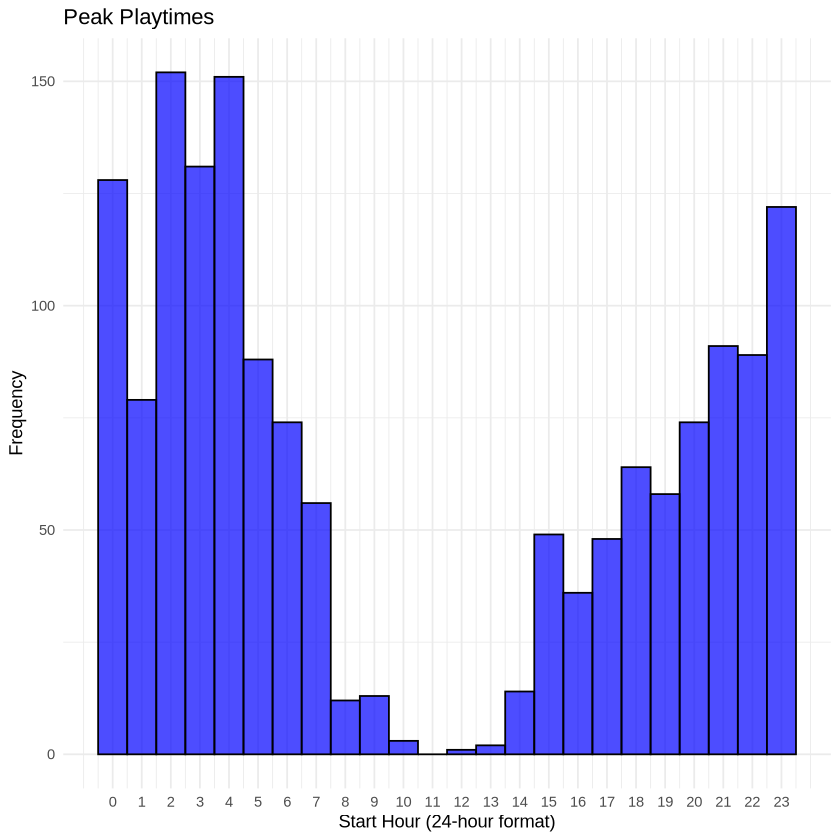

In [10]:
ggplot(player_session_select, aes(x = start_hour)) +
  geom_histogram(binwidth = 1, fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Peak Playtimes", 
       x = "Start Hour (24-hour format)", 
       y = "Frequency") +
  scale_x_continuous(breaks = seq(0, 23, 1)) +
  theme_minimal()

# Peak Playtime Histogram - For Age

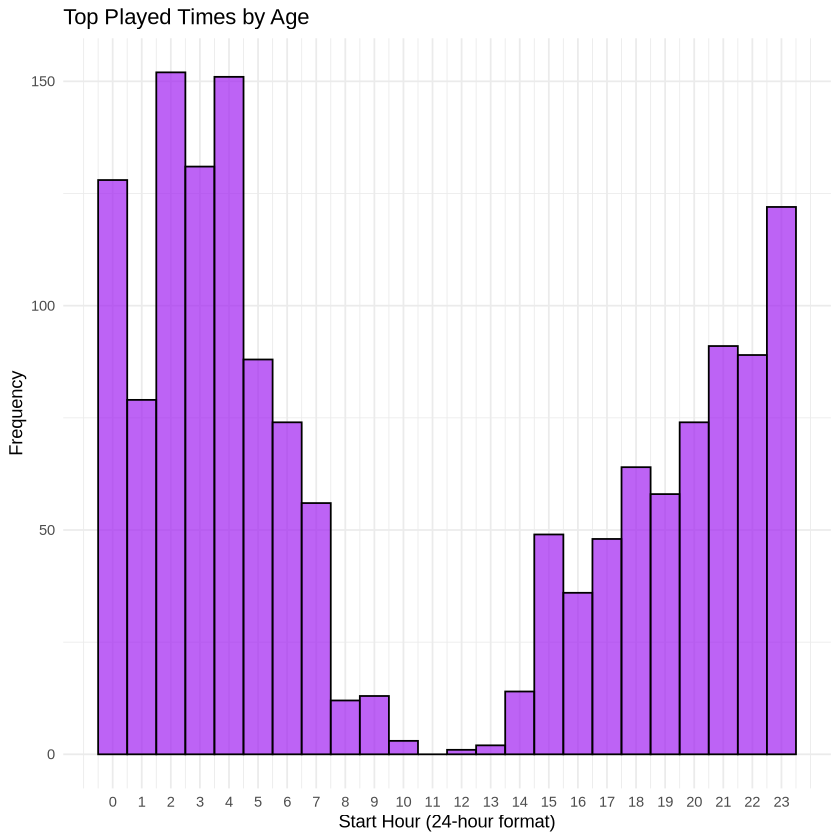

In [11]:
ggplot(player_session_select, aes(x = start_hour)) +
  geom_histogram(binwidth = 1, position = "dodge", fill = "purple", color = "black", alpha = 0.7) +
  labs(title = "Top Played Times by Age", 
       x = "Start Hour (24-hour format)", 
       y = "Frequency", 
       fill = "Age Group") +
  scale_x_continuous(breaks = seq(0, 23, 1)) +
  theme_minimal()

# Peak Playtime Histogram - For Experiance 

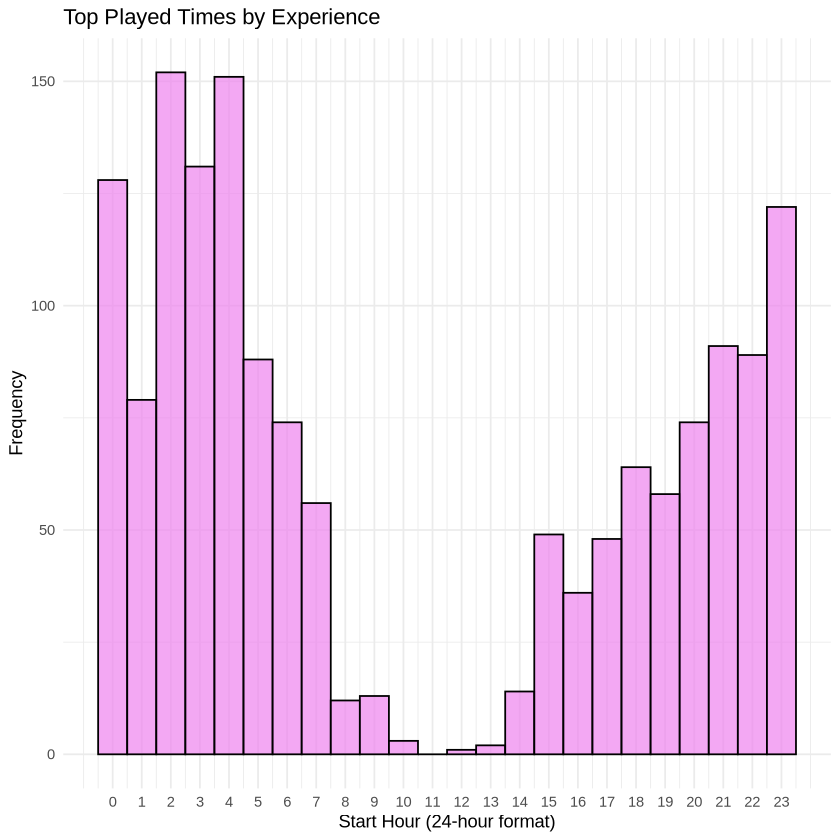

In [12]:
ggplot(player_session_select, aes(x = start_hour)) +
  geom_histogram(binwidth = 1, position = "dodge", fill = "violet", color = "black", alpha = 0.7) +
  labs(title = "Top Played Times by Experience", 
       x = "Start Hour (24-hour format)", 
       y = "Frequency", 
       fill = "Experience Level") +
  scale_x_continuous(breaks = seq(0, 23, 1)) +
  theme_minimal()

# Peak Playtime Histogram - For 20 Year Olds

# Methods and Results: Analyzing Player Behavior
## Histogram
Data Preparation:

Sessions Data: The sessions_data dataset contained player session start and end times. Key columns (start_time, end_time, hashedEmail) were extracted using the select() function.

Separating Date and Time: Using the separate() function, the start_time and end_time columns were split into separate date and time components, allowing for easier manipulation of time data.

Time Transformation: The start_time and end_time columns were converted into a POSIXct format to ensure accurate time-based calculations. Additionally, the hour() function was used to extract start_hour and end_hour, which represent the session start and end times as hours of the day.

Player Information:

From the players_data dataset, key demographic and experience-related columns (hashedEmail, experience, played_hours, name, gender, age) were selected for analysis.

Merging Data:

The session data and player demographic data were merged using full_join() on the common hashedEmail column. This combined data allowed for analysis of player activity in relation to their experience and demographics.
Data Cleaning:

After merging, unnecessary columns were removed, and only start_hour, experience, and age were retained. Missing values were dropped using drop_na() to ensure data integrity.

Visualization:

Histograms were created to explore how player activity varied by:
Overall peak playtimes (start hour frequency across all players).
Start hour frequency by player experience levels.
Start hour frequency by player age.
These visualizations were designed to identify patterns in player behavior, particularly focusing on the timing of peak activity.

Results
Peak Playtimes:

The histogram of peak playtimes shows two distinct periods of heightened activity:
Early morning (12 AM to 6 AM).
Evening (6 PM to 11 PM).
This suggests that players are most active either late at night or after typical working/school hours, with the highest play times occurring at 2:00 AM, 4:00 AM, and 11:00 PM, respectively.

Start Hour by Age:

The distribution of start times across age groups shows that younger players (ages 10-20) dominate the peak periods. Older players are less frequent overall but may align with similar time slots.
Insights and Relevance to the Question
The analysis demonstrates clear patterns in how start time, experience level, and age influence player behavior

Start Hour by Experience:

Players with different experience levels (e.g., Amateur, Regular, Beginner) exhibit similar peak playtimes, concentrated in early mornings and evenings. However, slight differences in frequency suggest that more experienced players may favor specific time slots slightly more, such as late evenings.

It's important to note that while the other histograms provide a more detailed breakdown of the factors influencing player behavior, the overall peak playtimes remain consistent.

## Knn Analysis

In [5]:
sessions_select <- sessions_data |>
    select(start_time, end_time, hashedEmail)

#seperating date and time 
sessions_seperate <- sessions_select |>
    separate(start_time, into = c("start_date", "start_time"), sep = " ") |>
    separate(end_time, into = c("end_date", "end_time"), sep = " ")

sessions_new <- sessions_seperate |>
   mutate(start_time = as.POSIXct(start_time, format = "%H:%M"),
          end_time = as.POSIXct(end_time, format = "%H:%M"),
         start_hour = hour(start_time),
         end_hour= hour(end_time))


#wrangling players
players_new <- players_data |>
    select(hashedEmail,experience, played_hours, name, gender, age)

#merge the data
players_session <- full_join(sessions_new, players_new, by = "hashedEmail")


player_session_select <- players_session |>
    select(start_hour, experience, played_hours) |>
    mutate(experience = as.factor(experience)) |>
    drop_na()

head(player_session_select)

start_hour,experience,played_hours
<int>,<fct>,<dbl>
18,Regular,223.1
23,Amateur,53.9
17,Amateur,150.0
3,Regular,223.1
16,Amateur,53.9
15,Regular,223.1


In [6]:
#using our evaluation for to do K-nearest neighbors 2 neighbors

#Classification with K-nearest

player_session_select_new <- players_session |>
    select(start_hour, experience, played_hours) |>
    mutate(
        experience = as.factor(experience),
        start_hour = as.integer(round(start_hour))
    ) |>
    drop_na()


knearest_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
  set_engine("kknn") |>
  set_mode("classification")

# create the centering / scaling recipe
knearest_recipe <- recipe(experience ~ start_hour + played_hours, data = player_session_select_new) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())


knn_fit <- workflow() |>
  add_recipe(knearest_recipe) |>
  add_model(knearest_knn_spec) |>
  fit(data = player_session_select_new)



start_grid <- seq(
    min(player_session_select_new$start_hour),
    max(player_session_select_new$start_hour),
    length.out = 100
)

played_grid <- seq(
    min(player_session_select_new$played_hours),
    max(player_session_select_new$played_hours),
    length.out = 100
)

asgrid <- as_tibble(expand.grid(
    start_hour = as.integer(round(start_grid)),  
    played_hours = played_grid
))



knnPredGrid <- predict(knn_fit, asgrid)


prediction_table <- bind_cols(knnPredGrid, asgrid) |>
  rename(experience = .pred_class)


options(repr.plot.width = 8, repr.plot.height = 8)

wkflw_plot <-
  ggplot() +
  geom_point(data = player_session_select_new ,
             mapping = aes(x = start_hour,
                           y = played_hours,
                           color = experience),
             alpha = 0.75) +
  geom_point(data = prediction_table,
             mapping = aes(x = start_hour,
                           y = played_hours,
                           color = experience),
             alpha = 0.1,
             size = 5) +
  labs(color = "Expereince Level",
       x = "Start hour",
       y = "Total Played hours") +
    scale_color_brewer(palette = "Set2") +
  theme(text = element_text(size = 12))

#wkflw_plot

In [13]:
#Evaluating peformance 

#creating a training set
player_session_split <- initial_split(player_session_select, prop = 0.75, strata = experience)  
player_session_train <- training(player_session_split)   
player_session_test <- testing(player_session_split)

#creating a recipe
player_session_recipe <- recipe(experience ~ start_hour + played_hours, data = player_session_train) |>
   step_upsample(experience, over_ratio = 1) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

#creating a knn_spec for 3 neighbors
player_session_spec1 <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
       set_engine("kknn") |>
       set_mode("classification")

#creating player_session workflow
player_session_fit <- workflow() |>
       add_recipe(player_session_recipe) |>
       add_model(player_session_spec1) |>
       fit(data = player_session_train)

#predicting 
player_session_predict <- predict(player_session_fit, player_session_test) |>
       bind_cols(player_session_test)

#creating a matrix 
player_session_mat <- player_session_predict |> 
       conf_mat(truth = experience, estimate = .pred_class)

head(player_session_predict)
player_session_mat

.pred_class,start_hour,experience,played_hours
<fct>,<int>,<fct>,<dbl>
Regular,18,Regular,223.1
Amateur,17,Amateur,150.0
Regular,3,Regular,223.1
Amateur,7,Amateur,56.1
Amateur,0,Amateur,53.9
Amateur,21,Amateur,53.9


          Truth
Prediction Amateur Beginner Pro Regular Veteran
  Amateur      190        3   3       3       0
  Beginner       4       16   1       5       3
  Pro            3        2   5       3       0
  Regular        6        3   0     126       0
  Veteran        2        2   2       2       1

In [14]:
#using 5 fold cross-validation
player_session_vfold5<- vfold_cv(player_session_train, v = 5, strata = experience)

#creating workflow for fit with 5 fold
player_session_resample_fit5 <- workflow() |>
       add_recipe(player_session_recipe) |>
       add_model(player_session_spec1) |>
       fit_resamples(resamples = player_session_vfold5)

#collecting and displaying metrics so see the accuracy of the the classifier with 5 fold
player_session_metrics5 <-player_session_resample_fit5 |>
collect_metrics()

player_session_metrics5

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,multiclass,0.8582790,5,0.01762064,Preprocessor1_Model1
roc_auc,hand_till,0.7980003,5,0.02632044,Preprocessor1_Model1


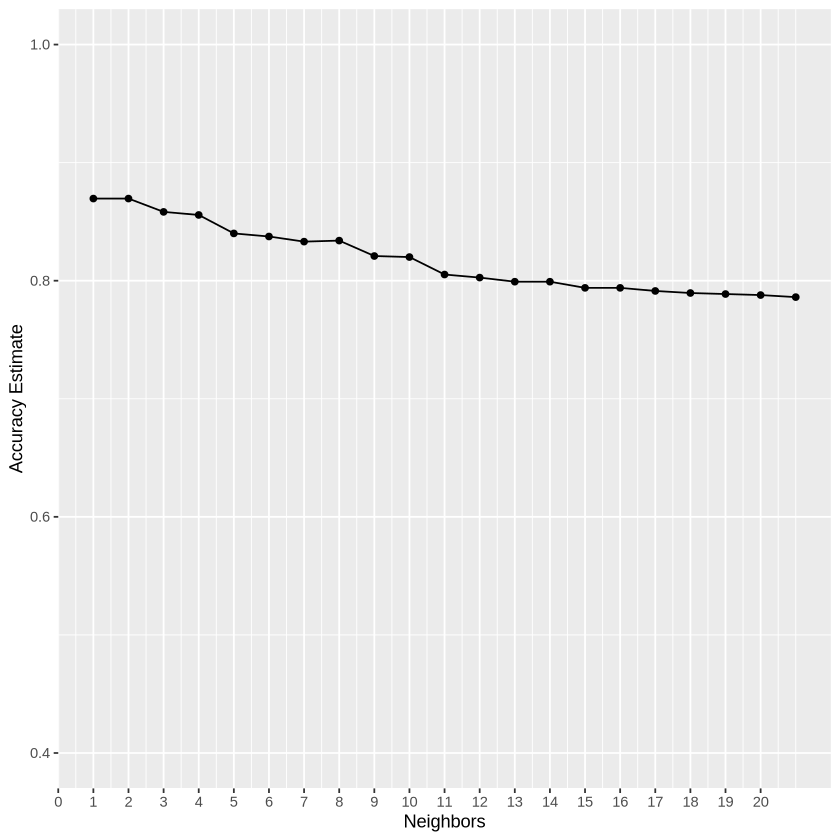

In [15]:
#Improving our classifier with 5 fold validated set 
set.seed(2020) 

#setting a new knn_spec
player_session_tune1 <- nearest_neighbor(weight_func = "rectangular",neighbors = tune())|>
    set_engine("kknn") |>
    set_mode("classification")

#inputing our recipie with our new model specification and putting a range of K's from 1-20 
k_grid1 <- tibble(neighbors = seq(from =1, to =21, by=1))

player_session_knn_results1 <- workflow() |>
       add_recipe(player_session_recipe) |>
       add_model(player_session_tune1) |>
      tune_grid(resamples = player_session_vfold5, grid = k_grid1) |>
       collect_metrics()

#creating a graph to see what K value is the best

accuracies5<- player_session_knn_results1 |> 
       filter(.metric == "accuracy")

accuracy_versus_k1 <- ggplot(accuracies5, aes(x = neighbors, y = mean)) +
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 20, by = 1)) +  
       scale_y_continuous(limits = c(0.4, 1.0)) 

accuracy_versus_k1


In [16]:
max_accuracies5 <- accuracies5 |> 
slice_max(mean, n=1)

max_accuracies5

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8695606,5,0.01109329,Preprocessor1_Model01
2,accuracy,multiclass,0.8695606,5,0.01109329,Preprocessor1_Model02


## Linear regression

In [ ]:
# Linear Regression

# Merge datasets on hashedEmail
merged_data <- merge(sessions_data, players_data, by = "hashedEmail")

# Convert start_time and end_time to datetime format
merged_data <- merged_data |>
    mutate(start_time = dmy_hm(start_time), end_time = dmy_hm(end_time))

# Create session_duration in minutes
merged_data <- merged_data |>
    mutate(session_duration = as.numeric(difftime(end_time, start_time, units = "mins")))

# Encode experience levels as numeric
# Beginner = 1, Amateur = 2, Regular = 3, Veteran = 4, Pro = 5
merged_data <- merged_data |>
    mutate(experience_encoded = as.numeric(factor(experience)))

# Filter necessary columns and remove missing values
filtered_data <- merged_data |>
    select(session_duration, experience_encoded, age) |>
    na.omit()

head(filtered_data)

In [ ]:
# Split the data into training (75%) and testing (25%) sets with stratification by 'age'
set.seed(123)  # For reproducibility
age_data_split <- initial_split(filtered_data, prop = 0.75, strata = age)
age_train_data <- training(age_data_split)
age_test_data <- testing(age_data_split)

# Model specification: Linear regression
age_lr_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")

# Create a recipe for preprocessing
age_lr_recipe <- recipe(age ~ session_duration + experience_encoded, data = age_train_data) |>
    step_normalize(all_numeric_predictors())

# Fit the linear regression model
age_lr_workflow <- workflow() |>
    add_model(age_lr_spec) |>
    add_recipe(age_lr_recipe) |>
    fit(data = age_train_data)
age_lr_workflow

# Generate predictions for the training data
age_train_predictions <- age_train_data |>
    mutate(.pred = predict(age_lr_workflow, new_data = age_train_data)|> 
    pull(.pred))

# Create the plot using the specified template
age_plot_final <- ggplot(age_train_data, aes(x = session_duration, y = age)) +
    geom_point(alpha = 0.4) +
    geom_line(data = age_train_predictions,
        mapping = aes(x = session_duration, y = .pred),
        color = "steelblue",
        linewidth = 1) +
    xlab("Session Duration (minutes)") +
    ylab("Age (years)") +
    theme(text = element_text(size = 20))

# Print the plot
age_plot_final

# Evaluate the model on the test data for age
test_results_age <- age_lr_workflow |>
    predict(age_test_data) |>
    bind_cols(age_test_data) |>
    metrics(truth = age, estimate = .pred)
test_results_age


# Split the data into training (75%) and testing (25%) sets with stratification by 'experience_encoded'
set.seed(123)  # For reproducibility
experience_encoded_data_split <- initial_split(filtered_data, prop = 0.75, strata = experience_encoded)
experience_encoded_train_data <- training(experience_encoded_data_split)
experience_encoded_test_data <- testing(experience_encoded_data_split)

# Model specification: Linear regression
experience_encoded_lr_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")

# Create a recipe for preprocessing
experience_encoded_lr_recipe <- recipe(experience_encoded ~ session_duration + age, data = experience_encoded_train_data) 

# Fit the linear regression model
experience_encoded_lr_workflow <- workflow() |>
    add_model(experience_encoded_lr_spec) |>
    add_recipe(experience_encoded_lr_recipe) |>
    fit(data = experience_encoded_train_data)
experience_encoded_lr_workflow

# Generate predictions for the training data
train_predictions_exp <- experience_encoded_train_data |>
    mutate(.pred = predict(experience_encoded_lr_workflow, new_data = experience_encoded_train_data)|> 
    pull(.pred))

# Create the plot for experience_encoded using the same template
experience_encoded_plot_exp <- ggplot(experience_encoded_train_data, aes(x = session_duration, y = experience_encoded)) +
    geom_point(alpha = 0.4) +
    geom_line(data = train_predictions_exp,
        mapping = aes(x = session_duration, y = .pred),
        color = "steelblue",
        linewidth = 1) +
    xlab("Session Duration (minutes)") +
    ylab("Experience Level (Encoded)") +
    theme(text = element_text(size = 20))

# Print the plot
experience_encoded_plot_exp

# Evaluate the model on the test data for experience_encoded
test_results_exp <- experience_encoded_lr_workflow |>
    predict(experience_encoded_test_data) |>
    bind_cols(experience_encoded_test_data) |>
    metrics(truth = experience_encoded, estimate = .pred)
test_results_exp

# Methods and Results
## Linear Regression

1. Data Preparation - 
Merging Datasets:
We started with two datasets: one containing session information (sessions) and another with player details (players).
These were merged using a common column, hashedEmail, to combine relevant details about sessions and players.
Time Conversion:
Session start and end times were stored as strings. Using lubridate, these were converted into datetime objects for accurate time manipulation.
Calculating Session Duration:
Session duration was computed as the difference between the end_time and start_time, resulting in a new variable, session_duration, measured in minutes.
Encoding Categorical Data:
The experience variable (e.g., "beginner", "intermediate", "expert") was encoded as a numeric variable (experience_encoded) using as.numeric(factor()). This allowed us to treat experience levels as numerical predictors in the linear regression model.
2. Data Cleaning - 
Column Selection: Only relevant variables (session_duration, experience_encoded, and age) were retained for the analysis.
Handling Missing Values: Rows with missing values were removed to ensure clean data for the models.
3. Data Splitting - 
To build and evaluate the models, the dataset was split into training (75%) and testing (25%) sets using initial_split().
Stratification: The splitting was stratified by age and experience_encoded to ensure the age and player experience distribution in both training and testing sets were consistent.
4. Model Specification and Preprocessing - 
Linear Regression Model:
A simple linear regression model was defined using tidymodels, specifically the linear_reg() function with the lm engine.
Recipe Creation:
A recipe() was built to preprocess the data, specifying the formula (e.g., age ~ session_duration + experience_encoded).
A step to normalize numeric predictors (step_normalize()) was included to scale the inputs.
5. Model Training - 
A workflow() was created to combine the model specification and preprocessing recipe.
The workflow was fit to the training data using the fit() function, creating a trained regression model.
6. Model Evaluation - 
The trained model was evaluated using the test data:
Predictions were generated with predict() on the test set.
Performance metrics, including Mean Absolute Error (MAE), Root Mean Square Error (RMSE), and R-squared.
7. Visualization - 
To visualize the results:
Scatter Plots: The actual age and experience_encoded values were plotted against session_duration using geom_point().
Regression Lines: The model’s predictions were overlaid as lines using geom_line() to show the linear relationships.
8. Interpretation - 
For Age:
The regression line highlighted how session duration and experience levels were related to players’ ages.
The slope of the line provided insight into whether longer sessions or higher experience levels were indicative of older or younger players.
For Experience:
Similarly, the analysis evaluated whether session duration correlated with player experience levels (experience_encoded).


# Histograms 
## Summary of Findings
The histograms reveal that players are most active during two distinct time periods: early in the morning (around 2:00 AM and 4:00 AM) and late at night (around 11:00 PM). This pattern was somewhat expected, as gaming often aligns with times when people have free time, such as after work, school, or other daily responsibilities. The early-morning peak, however, stands out and may be influenced by a younger player demographic, who are more likely to stay up late gaming. The consistency of these peaks across experience levels and age groups suggests that external factors like free time or social gaming habits drive these trends rather than individual player characteristics.

## Impact of Findings
These findings are crucial for managing server resources and planning recruitment efforts. Knowing that peak playtimes occur during these specific windows allows the research team to allocate server capacity more efficiently, avoiding crashes or lag during busy periods. Additionally, recruitment efforts could target players likely to be active during off-peak times to help distribute server load more evenly. This data-driven approach ensures a smoother gaming experience and maximizes the value of the research project. Understanding these patterns also highlights the importance of factoring player behavior into resource management decisions.

# Linear Regression 
## Summary of Findings
Age predictions: The linear regression model showed that there is no relationship between age and the session duration. Being older or younger made no difference on the session duration time. This is not what I expected because I thought that older players would have a longer session duration because they would have more leisure time compared to younger people who are busy with school and other things.

Player experience predictions: The linear regression model showed that there is a positive relationship between player experience and session duration. Players with more experience in the game tend to have a longer session duration. This is what I expected because you need to play for a longer time if you have a higher skill level.
## Impact of Findings
These findings tell us that age has little to no impact on session durations and it is more about experience levels. Also, it tells us that the game may be too difficult for beginner players which can cause them to have little play time. Using this information, the server host can add a small tutorial to guide beginners which may increase their time playing if they understand the basics.